# SETUP PATHS

In [1]:
WORKSPACE_PATH = 'workspace'
SCRIPTS_PATH = 'scripts'
APIMODEL_PATH = 'models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'

In [4]:
# ia.seed matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
import xml.etree.ElementTree as ET
import shutil

In [5]:
images_path = IMAGE_PATH + '/dataset'
anotasi_path = IMAGE_PATH + '/dataset'
aug_images_path = IMAGE_PATH + '/aug_images'

# XML to CSV


In [6]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(IMAGE_PATH + '/dataset/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [7]:
# Save File CSV

labels_df = xml_to_csv(IMAGE_PATH + '/dataset/')
labels_df.to_csv((ANNOTATION_PATH + '/RESIZE/labels.csv'), index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


In [3]:
# Read CSV File

labels_df = ANNOTATION_PATH + '/anotasi/annotation.csv'
labels_df 

'workspace/annotations/anotasi/annotation.csv'

In [7]:
# Menggrubkan setiap kordinat sesuai dengan nama file image
grouped = labels_df.groupby('filename')

In [8]:
# we can pull each group with get_group() using the filename
group_df = grouped.get_group('image 1.jpg')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
group_df

filename  width  height       class  xmin  ymin  xmax  ymax
0  image 1.jpg   2560    1600         car  1098   677  1212   799
1  image 1.jpg   2560    1600         car  1224   693  1369   841
2  image 1.jpg   2560    1600         car  1449   687  1604   836
3  image 1.jpg   2560    1600  motorcycle   420   657   583   963
4  image 1.jpg   2560    1600  motorcycle   755   663   903   997
5  image 1.jpg   2560    1600  motorcycle   908   682  1006   903
6  image 1.jpg   2560    1600  motorcycle  1702   696  1771   850

In [9]:
# get bounding boxes coordinates from grouped data frame and write into array        
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
# display the array we've got
bb_array

array([[1098,  677, 1212,  799],
       [1224,  693, 1369,  841],
       [1449,  687, 1604,  836],
       [ 420,  657,  583,  963],
       [ 755,  663,  903,  997],
       [ 908,  682, 1006,  903],
       [1702,  696, 1771,  850]], dtype=int64)

# Resize Image with Bbox

In [11]:
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
import pandas as pd

In [7]:
# RESIZE IMAGE

height_resize = iaa.Sequential([ 
    iaa.Resize({"height": 800, "width": 'keep-aspect-ratio'})
])

width_resize = iaa.Sequential([ 
    iaa.Resize({"height": 'keep-aspect-ratio', "width": 1280})
])

In [8]:
# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

In [14]:
def resize_imgaug(df, images_path, aug_images_path, image_prefix):
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')    
    
    for filename in df['filename'].unique():
    #   Get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)

        if group_df['height'].unique()[0] >= group_df['width'].unique()[0] and group_df['height'].unique()[0] > 600:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = height_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])
            
        elif group_df['width'].unique()[0] > group_df['height'].unique()[0] and group_df['width'].unique()[0] > 600:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = width_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])

    #     append image info without any changes if it's height and width are both less than 600px 
        else:
            aug_bbs_xy = pd.concat([aug_bbs_xy, group_df])
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [15]:
# Resize image with bbox ke dalam suatu folder
resized_images_df = resize_imgaug(labels_df, IMAGE_PATH+'/real_dataset/', '', '')

TypeError: string indices must be integers

In [14]:
# Read Data Hasil Resize
resized_images_df

filename width height       class   xmin   ymin   xmax  \
0           image 1.jpg  1280    800         car  549.0  338.5  606.0   
1           image 1.jpg  1280    800         car  612.0  346.5  684.5   
2           image 1.jpg  1280    800         car  724.5  343.5  802.0   
3           image 1.jpg  1280    800  motorcycle  210.0  328.5  291.5   
4           image 1.jpg  1280    800  motorcycle  377.5  331.5  451.5   
...                 ...   ...    ...         ...    ...    ...    ...   
21349  pothole (98).JPG  1280    800     pothole  583.0  461.0  615.0   
21350  pothole (99).JPG  1280    800     pothole  702.0  503.0  740.0   
21351  pothole (99).JPG  1280    800     pothole  670.0  488.0  729.0   
21352  pothole (99).JPG  1280    800     pothole  574.0  466.0  605.0   
21353  pothole (99).JPG  1280    800     pothole  467.0  479.0  511.0   

             ymax  
0      399.500000  
1      420.500000  
2      417.999969  
3      481.500000  
4      498.500000  
...           ...  
21349  467.000000  
21350  521.000000  
21351  501.000000  
21352  479.000000  
21353  493.000000  

[21354 rows x 8 columns]

In [15]:
# overwrite the labels.csv with updated info
resized_images_df.to_csv(ANNOTATION_PATH + '/anotasi_aug/labels.csv', index=False)

D:\virtual_env\taslinda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if __name__ == "__main__":


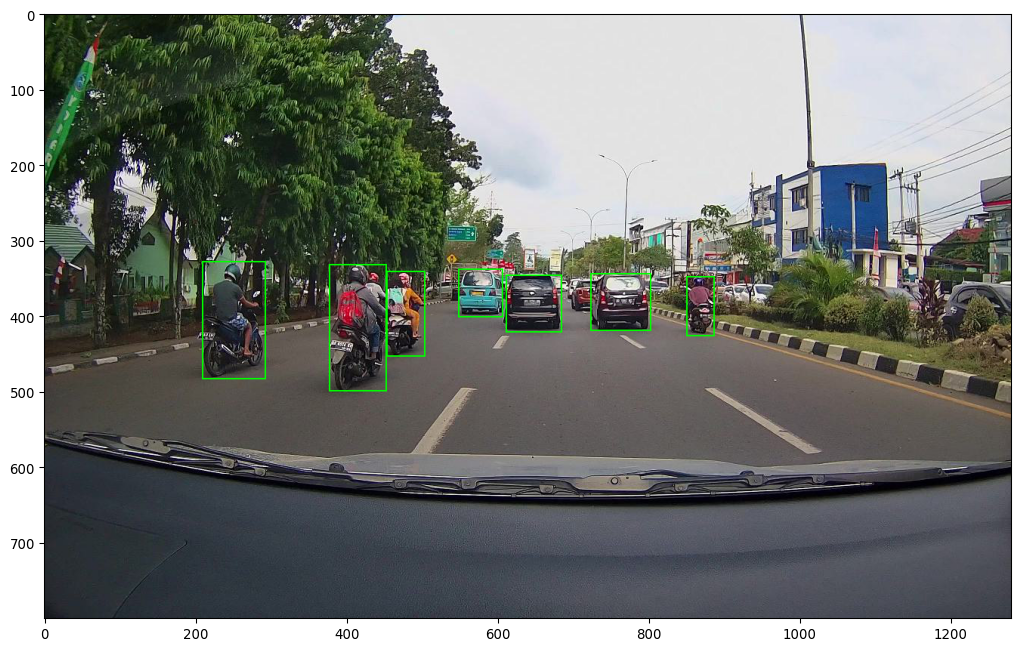

In [16]:
# Contoh gambar yg telah di resize

grouped = resized_images_df.groupby('filename')
group_df = grouped.get_group('image 1.jpg')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
image = imageio.imread('image 1.jpg')
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
ia.imshow(bbs.draw_on_image(image, size=2))

# Augmentation

In [17]:
# This setup of augmentation parameters will pick two of four given augmenters and apply them in random order
aug = iaa.SomeOf(2, [  
    iaa.Fliplr(1),
    iaa.Affine(scale=(0.5, 2.5)),
    iaa.pillike.EnhanceContrast()
    iaa.MultiplyBrightness((0.5, 1.5))
])

In [18]:
def image_aug(df, images_path, aug_images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
    #   read the image
        image = imageio.imread(images_path+filename)
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [19]:

# Apply augmentation to our images and save files into 'aug_images/' folder with 'aug1_' prefix.
# Write the updated images and bounding boxes annotations to the augmented_images_df dataframe.
augmented_images_df = image_aug(resized_images_df, '', IMAGE_PATH + '/aug_images/',  '', aug)

# resized_images_df = resize_imgaug(labels_df, IMAGE_PATH+'/real_dataset/', '', '')

D:\virtual_env\taslinda\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


In [20]:
# display new dataframe
augmented_images_df

filename width height       class        xmin        ymin  \
0           image 1.jpg  1280    800         car  674.000000  338.500000   
1           image 1.jpg  1280    800         car  595.500000  346.500000   
2           image 1.jpg  1280    800         car  478.000000  343.500000   
3           image 1.jpg  1280    800  motorcycle  988.500000  328.500000   
4           image 1.jpg  1280    800  motorcycle  828.500000  331.500000   
...                 ...   ...    ...         ...         ...         ...   
21331  pothole (98).JPG  1280    800     pothole  653.760986  433.576721   
21332  pothole (99).JPG  1280    800     pothole  396.515900  650.788635   
21333  pothole (99).JPG  1280    800     pothole  423.299133  614.265991   
21334  pothole (99).JPG  1280    800     pothole  725.219421  560.699524   
21335  pothole (99).JPG  1280    800     pothole  954.094482  592.352478   

              xmax        ymax  
0       731.000000  399.500000  
1       668.000000  420.500000  
2       555.500000  417.999969  
3      1070.000000  481.500000  
4       902.500000  498.500000  
...            ...         ...  
21331   671.375000  436.879364  
21332   489.039856  694.615784  
21333   566.954773  645.918945  
21334   800.699524  592.352478  
21335  1061.227539  626.440247  

[21336 rows x 8 columns]

D:\virtual_env\taslinda\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  # Remove the CWD from sys.path while we load stuff.
D:\virtual_env\taslinda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  app.launch_new_instance()


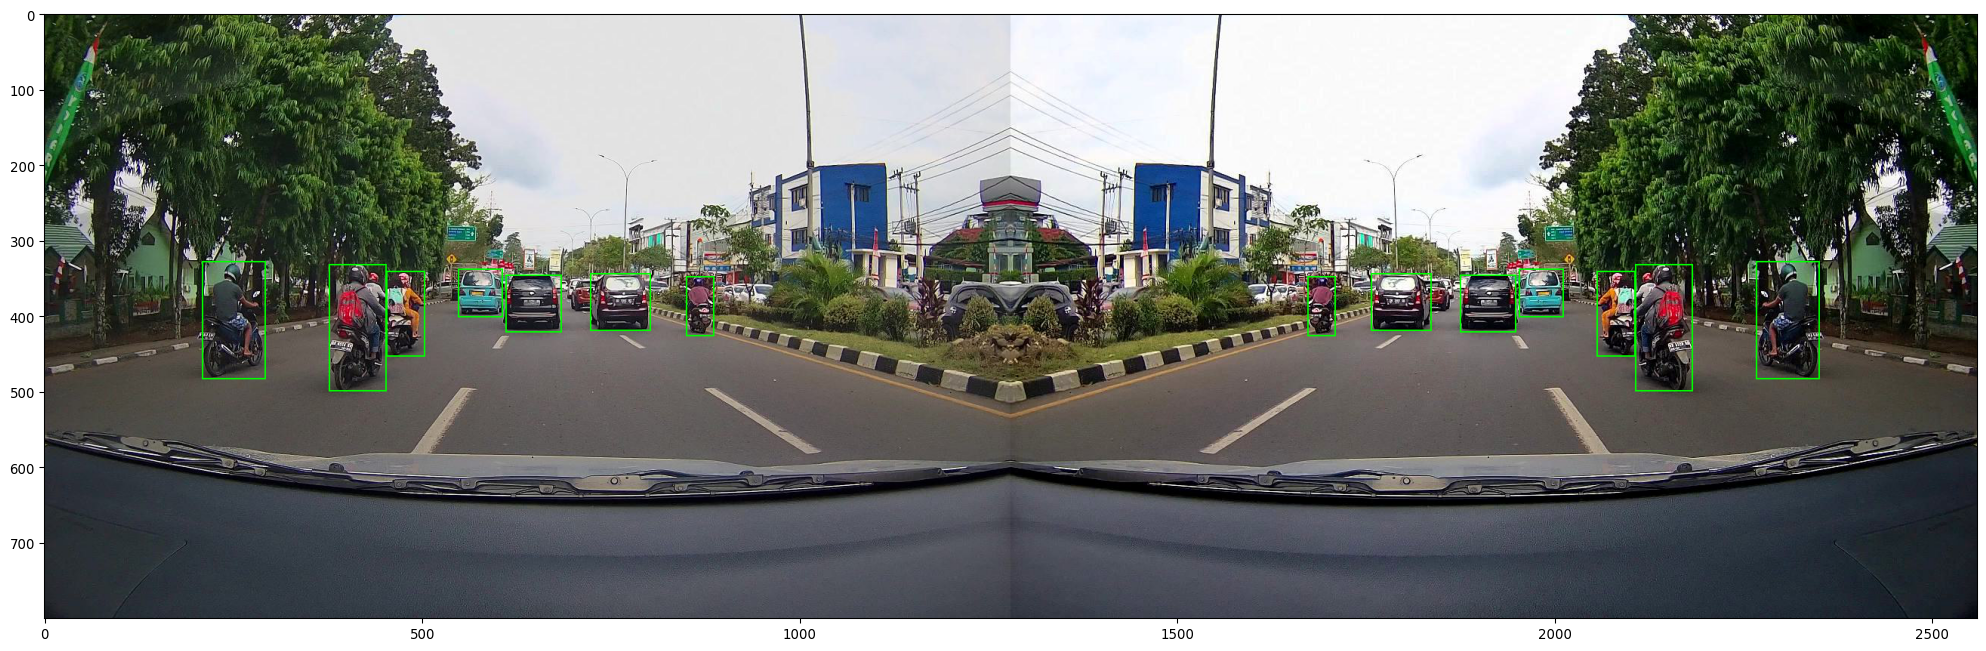

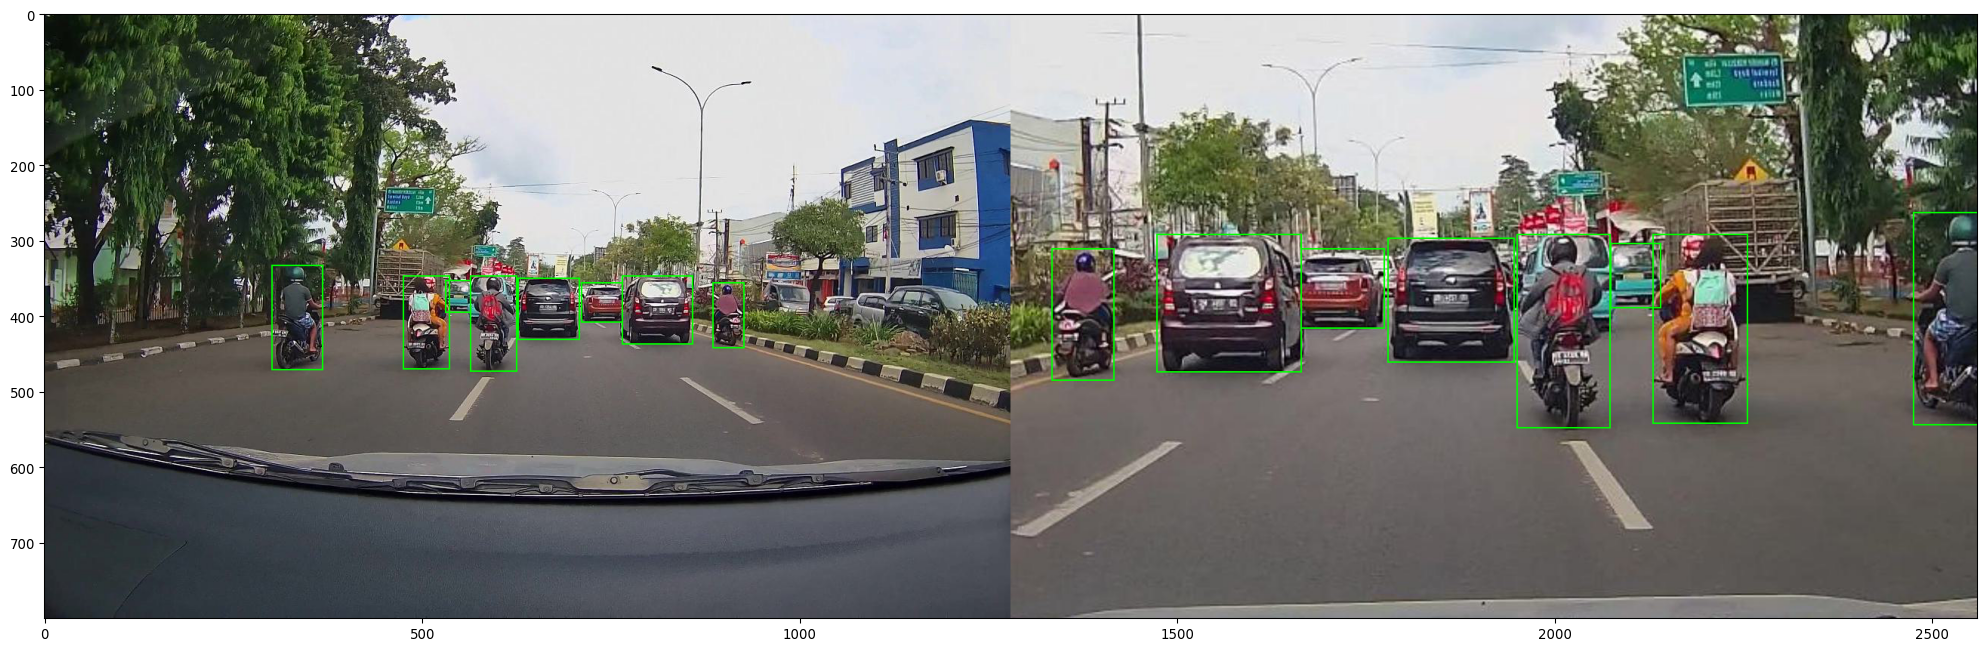

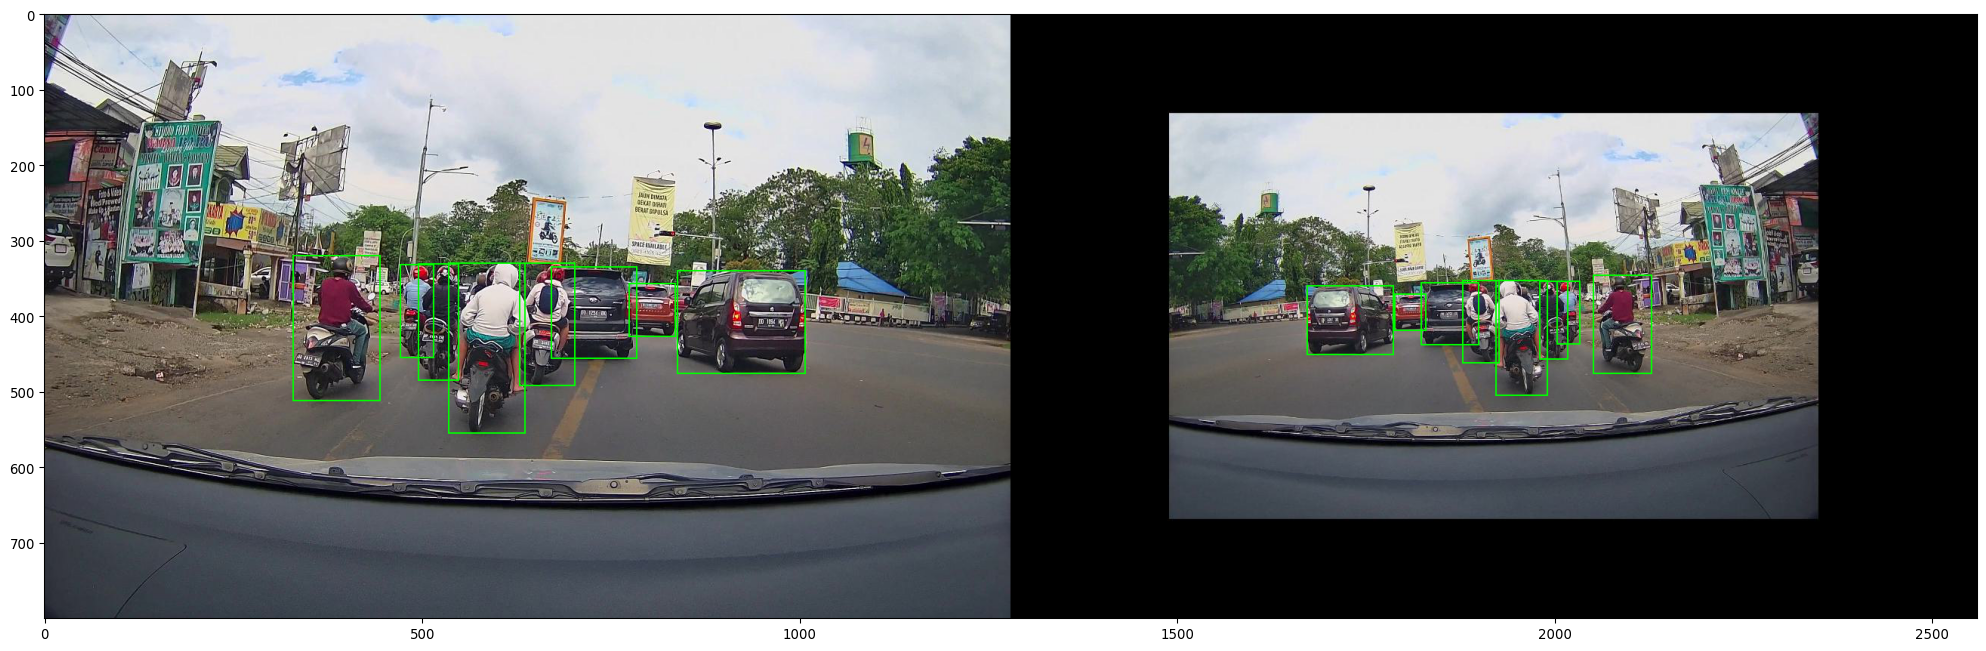

ValueError: cannot convert float NaN to integer

In [21]:
grouped_resized = resized_images_df.groupby('filename')
grouped_augmented = augmented_images_df.groupby('filename')

for filename in resized_images_df['filename'].unique():    
    
    group_r_df = grouped_resized.get_group(filename)
    group_r_df = group_r_df.reset_index()
    group_r_df = group_r_df.drop(['index'], axis=1)
    bb_r_array = group_r_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    resized_img = imageio.imread(''+filename)
    bbs_r = BoundingBoxesOnImage.from_xyxy_array(bb_r_array, shape=resized_img.shape)
    
    group_a_df = grouped_augmented.get_group(''+filename)
    group_a_df = group_a_df.reset_index()
    group_a_df = group_a_df.drop(['index'], axis=1)
    bb_a_array = group_a_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    augmented_img = imageio.imread(IMAGE_PATH + '/aug_images/'+''+filename)
    bbs_a = BoundingBoxesOnImage.from_xyxy_array(bb_a_array, shape=augmented_img.shape)
    
    ia.imshow(np.hstack([
            bbs_r.draw_on_image(resized_img, size=2),
            bbs_a.draw_on_image(augmented_img, size=2)
            ]))

In [26]:
# Concat resized_images_df and augmented_images_df together and save in a new all_labels.csv file
all_labels_df = pd.concat([resized_images_df, augmented_images_df])

In [27]:
all_labels_df.to_csv('all_labels.csv', index=False)